In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

W2(Relu((I+W)x))

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import numpy as np
class Net(nn.Module):

    def __init__(self, d):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(d, d, bias = False)
        self.fc2 = nn.Linear(d, d, bias = False)
        
    def forward(self, x):
        y = self.fc2(F.relu(self.fc1(x) + x))
        return torch.sum(y)

class TeacherNet(object):
  def __init__(self, d):
    self.W1 = torch.rand(d,d)
    self.W2 = torch.rand(d,d)
  def compute(self, x):
    return torch.sum(torch.mv(self.W2,F.relu(torch.mv(self.W1, x) + x)))
  def getWeights(self):
    return (self.W1, self.W2)


W2(Relu((I+W)x)) + x

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import numpy as np
class Net(nn.Module):

    def __init__(self, d):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(d, d, bias = False)
        self.fc2 = nn.Linear(d, d, bias = False)
        
    def forward(self, x):
        y = self.fc2(F.relu(self.fc1(x) + x)) + x
        return torch.sum(y)

class TeacherNet(object):
  def __init__(self, d):
    self.W1 = torch.rand(d,d)
    self.W2 = torch.rand(d,d)
  def compute(self, x):
    return torch.sum(torch.mv(self.W2,F.relu(torch.mv(self.W1, x) + x)) + x)
  def getWeights(self):
    return (self.W1, self.W2)

In [0]:
d = 10

teacher = TeacherNet(d)
inputs = []
trueOutputs = []
for i in range(100000):
  # x is sampled N 0,1
  x = np.random.multivariate_normal(np.zeros(d), np.identity(d))
  x = torch.from_numpy(x)
  x = x.float()
  y = teacher.compute(x)
  inputs.append(x)
  trueOutputs.append(y)

In [0]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, featureList, outputList):
    self.featureList = featureList
    self.outputList = outputList
    assert len(featureList) == len(outputList)
  def __getitem__(self,idx):
    return self.featureList[idx], self.outputList[idx]
  def __len__(self):
    return len(self.featureList)

In [0]:
import torch.utils.data as utils
dataset = MyDataset(inputs, trueOutputs)
trainloader = utils.DataLoader(dataset, batch_size = 200,
                               shuffle = True, num_workers = 2)

In [0]:
import torch.optim as optim
net = Net(d)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = .01, nesterov = True)


In [55]:
iterations = 0
losses = []
iterationNumbers = []
num_batches = 250
epochs = 100
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs
      features, values = data
      
      # zero the parameter gradients
      optimizer.zero_grad()
      
      # forward + backward + optimize
      outputlist = []
      for feature in features:
        outputlist.append(net(feature))
      outputs = torch.stack([j for j in outputlist])
      loss = criterion(outputs, values)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      
      if i % num_batches == (num_batches - 1):
        # find the distance between parameters
        params = list(net.parameters())
        studentW1 = params[0]
        studentW2 = params[1]
        (teacherW1, teacherW2) = teacher.getWeights()
        distance = np.linalg.norm(studentW1.data.numpy() - teacherW1.data.numpy()) + np.linalg.norm(studentW2.data.numpy() - teacherW2.data.numpy())
        studentW1Norm = np.linalg.norm(studentW1.data.numpy())
        studentW2Norm = np.linalg.norm(studentW2.data.numpy())
        losses.append(running_loss/num_batches)
        iterationNumbers.append(iterations)
        print('[%d, %5d] loss: %.3f, distance: %.4f, norm1: %.3f, norm2: %.3f' %
            (epoch + 1, i + 1, running_loss/num_batches, distance, 
            studentW1Norm, studentW2Norm))
        running_loss = 0.0
      iterations += 1

print('Finished Training')

[1,   250] loss: 130.085, distance: 8.3565, norm1: 4.950, norm2: 5.959
[1,   500] loss: 6.591, distance: 7.7387, norm1: 4.945, norm2: 5.956
[2,   250] loss: 4.124, distance: 7.3087, norm1: 4.939, norm2: 5.948
[2,   500] loss: 2.908, distance: 7.0059, norm1: 4.955, norm2: 5.952
[3,   250] loss: 2.130, distance: 6.7899, norm1: 4.958, norm2: 5.946
[3,   500] loss: 1.663, distance: 6.6234, norm1: 4.966, norm2: 5.949
[4,   250] loss: 1.359, distance: 6.4973, norm1: 4.971, norm2: 5.948
[4,   500] loss: 1.151, distance: 6.3945, norm1: 4.971, norm2: 5.945
[5,   250] loss: 0.994, distance: 6.3215, norm1: 4.977, norm2: 5.946
[5,   500] loss: 0.861, distance: 6.2623, norm1: 4.980, norm2: 5.947
[6,   250] loss: 0.783, distance: 6.2186, norm1: 4.983, norm2: 5.946
[6,   500] loss: 0.715, distance: 6.1833, norm1: 4.985, norm2: 5.947
[7,   250] loss: 0.674, distance: 6.1628, norm1: 4.989, norm2: 5.947
[7,   500] loss: 0.630, distance: 6.1453, norm1: 4.992, norm2: 5.946
[8,   250] loss: 0.613, distance

Process Process-1323:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process Process-1324:
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 131, in get
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
    if not self._poll(timeout):
  File "/usr/lib/p

KeyboardInterrupt: ignored

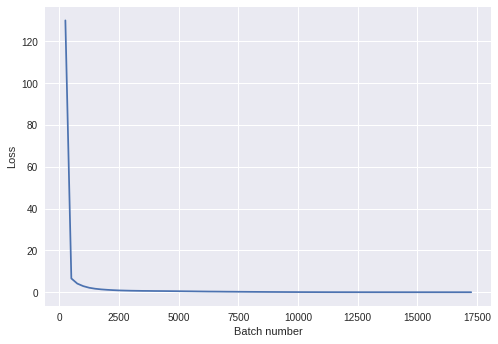

In [56]:
import matplotlib.pylab as plt
plt.plot(iterationNumbers, losses)
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.show()